In [1]:
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn import tree
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn import neighbors
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def clean_data(df, drop_passenger_id):
    
    # Get the unique values of Sex
    sexes = sorted(df['Sex'].unique())
    
    # Generate a mapping of Sex from a string to a number representation    
    genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))

    # Transform Sex from a string to a number representation
    df['Sex_Val'] = df['Sex'].map(genders_mapping).astype(int)
    
    # Get the unique values of Embarked
    embarked_locs = sorted(df['Embarked'].fillna('S').unique())

    # Generate a mapping of Embarked from a string to a number representation        
    embarked_locs_mapping = dict(zip(embarked_locs, 
                                     range(0, len(embarked_locs) + 1)))
    
    # Transform Embarked from a string to dummy variables
    df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked_Val')], axis=1)
    
    # Fill in missing values of Embarked
    # Since the vast majority of passengers embarked in 'S': 3, 
    # we assign the missing values in Embarked to 'S':
#     if len(df[df['Embarked'].isnull()] > 0):
#         df.replace({'Embarked_Val' : 
#                        { embarked_locs_mapping[np.nan] : embarked_locs_mapping['S'] 
#                        }
#                    }, 
#                    inplace=True)
    
#     Fill in missing values of Fare with the average Fare
#     if len(df[df['Fare'].isnull()] > 0):
#         avg_fare = df['Fare'].mean()
#         df.replace({ None: avg_fare }, inplace=True)
    
    df['Fare'].fillna(df['Fare'].mean())
    
    # To keep Age intact, make a copy of it called AgeFill 
    # that we will use to fill in the missing ages:
    df['AgeFill'] = df['Age']

    # Determine the Age typical for each passenger class by Sex_Val.  
    # We'll use the median instead of the mean because the Age 
    # histogram seems to be right skewed.
    df['AgeFill'] = df['AgeFill'] \
                        .groupby([df['Sex_Val'], df['Pclass']]) \
                        .apply(lambda x: x.fillna(x.median()))
            
    # Define a new feature FamilySize that is the sum of 
    # Parch (number of parents or children on board) and 
    # SibSp (number of siblings or spouses):
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    # Drop the columns we won't use:
    df = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    
    # Drop the Age column since we will be using the AgeFill column instead.
    # Drop the SibSp and Parch columns since we will be using FamilySize.
    # Drop the PassengerId column since it won't be used as a feature.
    df = df.drop(['Age', 'SibSp', 'Parch'], axis=1)
    
    if drop_passenger_id:
        df = df.drop(['PassengerId'], axis=1)
    
    return df

In [3]:
df_train = pd.read_csv("titanic_train.csv") 
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
df_train = clean_data(df_train, drop_passenger_id=True)
df_train.head()

,Survived,Pclass,Fare,Sex_Val,Embarked_Val_C,Embarked_Val_Q,Embarked_Val_S,AgeFill,FamilySize
0,0,3,7.2500,1,0,0,1,22.0,1
1,1,1,71.2833,0,1,0,0,38.0,1
2,1,3,7.9250,0,0,0,1,26.0,0
3,1,1,53.1000,0,0,0,1,35.0,1
4,0,3,8.0500,1,0,0,1,35.0,0


In [5]:
#Convert the DataFrame to a numpy array:
train_data = df_train.values
train_data

array([[  0.    ,   3.    ,   7.25  , ...,   1.    ,  22.    ,   1.    ],
       [  1.    ,   1.    ,  71.2833, ...,   0.    ,  38.    ,   1.    ],
       [  1.    ,   3.    ,   7.925 , ...,   1.    ,  26.    ,   0.    ],
       ..., 
       [  0.    ,   3.    ,  23.45  , ...,   1.    ,  21.5   ,   3.    ],
       [  1.    ,   1.    ,  30.    , ...,   0.    ,  26.    ,   0.    ],
       [  0.    ,   3.    ,   7.75  , ...,   0.    ,  32.    ,   0.    ]])

In [6]:
# Training data features, skip the first column 'Survived'
X = train_data[:, 1:]
X[:5]

array([[  3.    ,   7.25  ,   1.    ,   0.    ,   0.    ,   1.    ,
         22.    ,   1.    ],
       [  1.    ,  71.2833,   0.    ,   1.    ,   0.    ,   0.    ,
         38.    ,   1.    ],
       [  3.    ,   7.925 ,   0.    ,   0.    ,   0.    ,   1.    ,
         26.    ,   0.    ],
       [  1.    ,  53.1   ,   0.    ,   0.    ,   0.    ,   1.    ,
         35.    ,   1.    ],
       [  3.    ,   8.05  ,   1.    ,   0.    ,   0.    ,   1.    ,
         35.    ,   0.    ]])

In [7]:
# 'Survived' column values
y = train_data[:, 0]
y[:5]

array([ 0.,  1.,  1.,  1.,  0.])

In [87]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [88]:
pred_target = clf.predict(X)

print(metrics.precision_score(y, pred_target, average='weighted'))
print(metrics.recall_score(y, pred_target, average='weighted'))
print(metrics.f1_score(y, pred_target, average='weighted'))
print(metrics.accuracy_score(y, pred_target))
print(metrics.precision_recall_fscore_support(y, pred_target))

0.896873629589
0.895622895623
0.894173769835
0.895622895623
(array([ 0.88644068,  0.91362126]), array([ 0.95264117,  0.80409357]), array([ 0.91834943,  0.85536547]), array([549, 342]))


In [89]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.10, 
                                                    random_state=0)

In [90]:
train_pred = clf.predict(train_x)
test_pred = clf.predict(test_x)

In [91]:
print(metrics.accuracy_score(train_y, train_pred))
print(metrics.accuracy_score(test_y, test_pred))

0.896379525593
0.888888888889


In [92]:
cm = confusion_matrix(test_y, test_pred)
print(cm)

[[46  5]
 [ 5 34]]


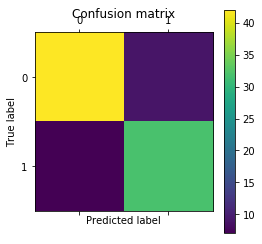

In [73]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [93]:
from sklearn.metrics import classification_report
print(classification_report(test_y, 
                            test_pred, 
                            target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.90      0.90      0.90        51
    Survived       0.87      0.87      0.87        39

 avg / total       0.89      0.89      0.89        90



In [94]:
# cross validation
scores = cross_validation.cross_val_score(clf, X, y, cv=5)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.70 (+/- 0.08)


In [95]:
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [19]:
svm.SVC??

In [77]:
# 
param_dist = {
    "C": np.arange(1.0, 10., 0.1)# ToDo
    ,"gamma": np.arange(0.0, 1., 0.01)
,"coef0": np.arange(0.0, 2., 0.01)
, "tol": [1e-7, 1e-8, 1e-9]
             }

n_iter_search = 424
search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, 
                            n_jobs=4, scoring=make_scorer(accuracy_score))

In [53]:
%time
search.fit(X, y)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=424, n_jobs=4,
          param_distributions={'gamma': array([ 0.  ,  0.01, ...,  0.98,  0.99]), 'coef0': array([ 0.  ,  0.01, ...,  1.98,  1.99]), 'tol': [1e-07, 1e-08, 1e-09], 'C': array([ 1. ,  1.1, ...,  9.8,  9.9])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=make_scorer(accuracy_score),
          verbose=0)

In [78]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [55]:
report(search.cv_results_, 3) #search.best_estimator_.estimators_[0]

Model with rank: 1
Mean validation score: 0.759 (std: 0.021)
Parameters: {'gamma': 0.01, 'coef0': 0.70999999999999996, 'C': 7.0000000000000053, 'tol': 1e-08}

Model with rank: 1
Mean validation score: 0.759 (std: 0.018)
Parameters: {'gamma': 0.01, 'coef0': 0.01, 'C': 8.8000000000000078, 'tol': 1e-07}

Model with rank: 3
Mean validation score: 0.728 (std: 0.021)
Parameters: {'gamma': 0.02, 'coef0': 0.96999999999999997, 'C': 7.9000000000000057, 'tol': 1e-09}

